# Baseline Models - AAPL Microstructure Prediction

**Objective:** Establish baseline prediction performance using logistic regression before applying tree-based models.

**Inputs:**

- Features with regimes from notebook 30 (`AAPL_features_with_regimes.parquet`)
- PCA features from notebook 25 (optional comparison)
- **Time period:** December 9-13, 2024 (5 trading days)

**Models:**

- Logistic Regression (L2 regularization)
- Logistic Regression with L1 (Lasso) for feature selection

**Outputs:**

- Baseline performance metrics (accuracy, precision, recall, F1, ROC-AUC)
- Trained baseline models
- Feature importance from coefficients
- Performance comparison: full features vs PCA features

**Target Variable:** Next-period mid-price direction (up=1, down=0)


## 1. Setup and Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
import warnings

warnings.filterwarnings("ignore")

# Sklearn imports
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
)

# Visualization
# Visualization settings
plt.style.use("seaborn-v0_8-paper")
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.weight": "bold",
        "axes.labelweight": "bold",
        "axes.titleweight": "bold",
        "axes.linewidth": 1.2,
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)

# Import project config
import sys

sys.path.append("..")
from src.config import PROCESSED_DATA_DIR, MODELS_DIR, FIGURES_DIR, TABLES_DIR

# Create output directories
baseline_dir = FIGURES_DIR / "baseline_models"
baseline_dir.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

# Set random seed
np.random.seed(42)

print(" Setup complete")
print(f"  Data directory: {PROCESSED_DATA_DIR}")
print(f"  Models directory: {MODELS_DIR}")
print(f"  Figures directory: {baseline_dir}")

 Setup complete
  Data directory: /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../data/processed
  Models directory: /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../models
  Figures directory: /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/baseline_models


In [2]:
# Configuration
TICKER = "AAPL"
START_DATE = "2024-12-09"  # Start date for multi-day data
END_DATE = "2024-12-13"  # End date for multi-day data
DATE_RANGE = f"{START_DATE}_to_{END_DATE}"  # File naming convention

print(f"Ticker: {TICKER}")
print(f"Date range: {START_DATE} to {END_DATE}")
print(f"Working with 5 days of data for baseline model training")

Ticker: AAPL
Date range: 2024-12-09 to 2024-12-13
Working with 5 days of data for baseline model training


## 2. Load Data


In [3]:
# Load features with regimes from notebook 30
print("Loading features with regimes...")
features_with_regimes = pd.read_parquet(
    PROCESSED_DATA_DIR / "AAPL_features_with_regimes.parquet"
).reset_index(drop=True)

print(f" Features with regimes: {features_with_regimes.shape}")
print(
    f"  Date range: {features_with_regimes['timestamp'].min()} to {features_with_regimes['timestamp'].max()}"
)
print(f"  Columns: {len(features_with_regimes.columns)}")

# Show regime distribution
print("\nRegime distribution:")
print(features_with_regimes["regime_hmm"].value_counts())

Loading features with regimes...
 Features with regimes: (1365, 94)
  Date range: 2024-12-09 20:42:00+00:00 to 2024-12-14 00:58:00+00:00
  Columns: 94

Regime distribution:
regime_hmm
Trending    526
Calm        520
Volatile    319
Name: count, dtype: int64


## 3. Create Target Variable

Predict next-period mid-price direction: up (1) or down (0)


In [4]:
# Find price column
price_candidates = ["agg_mid_price", "agg_close", "mid_price", "close"]
price_col = next(
    (col for col in price_candidates if col in features_with_regimes.columns), None
)

if price_col is None:
    raise ValueError(
        f"No price column found. Available columns: {features_with_regimes.columns.tolist()[:20]}"
    )

print(f"Using price column: {price_col}")

# Create target: 1 if next price > current price, 0 otherwise
features_with_regimes["price_next"] = features_with_regimes[price_col].shift(-1)
features_with_regimes["target"] = (
    features_with_regimes["price_next"] > features_with_regimes[price_col]
).astype(int)

# Remove last row (no future price)
features_with_regimes = features_with_regimes[:-1].copy()

print(f"\n Target variable created")
print(f"  Shape after removing last row: {features_with_regimes.shape}")
print(f"\nTarget distribution:")
target_counts = features_with_regimes["target"].value_counts()
print(
    f"  Down (0): {target_counts.get(0, 0):,} ({100*target_counts.get(0, 0)/len(features_with_regimes):.1f}%)"
)
print(
    f"  Up (1): {target_counts.get(1, 0):,} ({100*target_counts.get(1, 0)/len(features_with_regimes):.1f}%)"
)

Using price column: agg_mid_price

 Target variable created
  Shape after removing last row: (1364, 96)

Target distribution:
  Down (0): 715 (52.4%)
  Up (1): 649 (47.6%)


## 4. Feature Selection

Select microstructure features for modeling (exclude metadata and target)


In [5]:
# Columns to exclude from features
exclude_cols = [
    "timestamp",
    "target",
    "price_next",
    "regime_hmm",
    "regime_hawkes",
    "regime_hawkes_binary",
    "hmm_state",
    "time_hour",
    "time_minute",
    "time_minutes_since_open",
    "time_session",
    "hour",
    "minute",
    "time_of_day",
]

# Get feature columns
feature_cols = [col for col in features_with_regimes.columns if col not in exclude_cols]

# Select only numeric features
X = features_with_regimes[feature_cols].select_dtypes(include=[np.number])
feature_cols = X.columns.tolist()

print(f"Selected {len(feature_cols)} numeric features")
print(f"\nFirst 20 features:")
print(feature_cols[:20])

# Get target
y = features_with_regimes["target"].values

print(f"\n Feature matrix: {X.shape}")
print(f" Target vector: {y.shape}")

Selected 81 numeric features

First 20 features:
['agg_volume', 'agg_vwap', 'agg_open', 'agg_close', 'agg_high', 'agg_low', 'agg_trades', 'agg_estimated_spread', 'agg_mid_price', 'agg_relative_spread', 'agg_typical_price', 'agg_vwap_deviation', 'agg_price_range', 'agg_intrabar_momentum', 'agg_parkinson_vol', 'agg_gk_vol', 'agg_realized_vol_5min', 'agg_realized_vol_15min', 'agg_realized_vol_30min', 'agg_spread_5min_mean']

 Feature matrix: (1364, 81)
 Target vector: (1364,)


## 5. Handle Missing Values


In [6]:
# Check for missing values
missing_counts = X.isnull().sum()
if missing_counts.sum() > 0:
    print(f"Missing values detected: {missing_counts.sum()}")
    print("\nColumns with missing values:")
    print(missing_counts[missing_counts > 0].head(10))

    # Fill missing values
    X = X.fillna(method="ffill").fillna(method="bfill").fillna(0)
    print(f"\n✓ Filled missing values")
else:
    print("✓ No missing values")

# Check for infinite values
inf_counts = np.isinf(X).sum()
if inf_counts.sum() > 0:
    print(f"\nInfinite values detected: {inf_counts.sum()}")
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    print(" Replaced infinite values")
else:
    print(" No infinite values")

print(f"\n Clean feature matrix: {X.shape}")

✓ No missing values
 No infinite values

 Clean feature matrix: (1364, 81)


## 6. Train-Test Split (Time-Series)

Use 80-20 split, preserving temporal order


In [7]:
# Time-series split (no shuffling)
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

print(f"Train set: {X_train.shape[0]:,} samples ({100*len(X_train)/len(X):.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({100*len(X_test)/len(X):.1f}%)")

print("\nTrain target distribution:")
train_counts = pd.Series(y_train).value_counts()
print(
    f"  Down (0): {train_counts.get(0, 0):,} ({100*train_counts.get(0, 0)/len(y_train):.1f}%)"
)
print(
    f"  Up (1): {train_counts.get(1, 0):,} ({100*train_counts.get(1, 0)/len(y_train):.1f}%)"
)

print("\nTest target distribution:")
test_counts = pd.Series(y_test).value_counts()
print(
    f"  Down (0): {test_counts.get(0, 0):,} ({100*test_counts.get(0, 0)/len(y_test):.1f}%)"
)
print(
    f"  Up (1): {test_counts.get(1, 0):,} ({100*test_counts.get(1, 0)/len(y_test):.1f}%)"
)

Train set: 1,091 samples (80.0%)
Test set: 273 samples (20.0%)

Train target distribution:
  Down (0): 583 (53.4%)
  Up (1): 508 (46.6%)

Test target distribution:
  Down (0): 132 (48.4%)
  Up (1): 141 (51.6%)


## 7. Feature Standardization


In [8]:
# Standardize features (required for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f" Scaled features")
print(f"  Train mean: {X_train_scaled.mean():.6f} (should be ~0)")
print(f"  Train std: {X_train_scaled.std():.6f} (should be ~1)")
print(f"  Test mean: {X_test_scaled.mean():.6f}")
print(f"  Test std: {X_test_scaled.std():.6f}")

 Scaled features
  Train mean: -0.000000 (should be ~0)
  Train std: 0.993808 (should be ~1)
  Test mean: 0.102748
  Test std: 1.004313


## 8. Baseline Model 1: Logistic Regression (L2)

Ridge regularization (L2 penalty)


In [9]:
# Train logistic regression with L2 penalty
print("Training Logistic Regression (L2)...")

lr_l2 = LogisticRegression(
    penalty="l2",
    C=1.0,  # Inverse regularization strength
    max_iter=1000,
    random_state=42,
    solver="lbfgs",
    class_weight="balanced",  # Handle class imbalance
)

lr_l2.fit(X_train_scaled, y_train)

print(" Training complete")
print(f"  Converged: {lr_l2.n_iter_[0] < lr_l2.max_iter}")
print(f"  Iterations: {lr_l2.n_iter_[0]}")

Training Logistic Regression (L2)...
 Training complete
  Converged: True
  Iterations: 91


## 9. Evaluate L2 Model


In [10]:
# Predictions
y_train_pred_l2 = lr_l2.predict(X_train_scaled)
y_test_pred_l2 = lr_l2.predict(X_test_scaled)
y_test_proba_l2 = lr_l2.predict_proba(X_test_scaled)[:, 1]

# Metrics
print("=" * 80)
print("LOGISTIC REGRESSION (L2) PERFORMANCE")
print("=" * 80)

print("\nTRAIN SET:")
print(f"  Accuracy:  {accuracy_score(y_train, y_train_pred_l2):.4f}")
print(f"  Precision: {precision_score(y_train, y_train_pred_l2):.4f}")
print(f"  Recall:    {recall_score(y_train, y_train_pred_l2):.4f}")
print(f"  F1-score:  {f1_score(y_train, y_train_pred_l2):.4f}")

print("\nTEST SET:")
print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred_l2):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred_l2):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred_l2):.4f}")
print(f"  F1-score:  {f1_score(y_test, y_test_pred_l2):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, y_test_proba_l2):.4f}")

# Confusion matrix
cm_l2 = confusion_matrix(y_test, y_test_pred_l2)
print("\nConfusion Matrix (Test):")
print(cm_l2)

LOGISTIC REGRESSION (L2) PERFORMANCE

TRAIN SET:
  Accuracy:  0.7287
  Precision: 0.7062
  Recall:    0.7146
  F1-score:  0.7104

TEST SET:
  Accuracy:  0.6813
  Precision: 0.7250
  Recall:    0.6170
  F1-score:  0.6667
  ROC-AUC:   0.7337

Confusion Matrix (Test):
[[99 33]
 [54 87]]


## 10. Baseline Model 2: Logistic Regression (L1)

Lasso regularization (L1 penalty) - performs feature selection


In [11]:
# Train logistic regression with L1 penalty
print("Training Logistic Regression (L1)...")

lr_l1 = LogisticRegression(
    penalty="l1",
    C=1.0,
    max_iter=1000,
    random_state=42,
    solver="liblinear",  # L1 requires liblinear or saga
    class_weight="balanced",
)

lr_l1.fit(X_train_scaled, y_train)

# Count non-zero coefficients
n_nonzero = np.sum(lr_l1.coef_ != 0)
n_features = lr_l1.coef_.shape[1]

print(" Training complete")
print(f"  Converged: {lr_l1.n_iter_[0] < lr_l1.max_iter}")
print(f"  Iterations: {lr_l1.n_iter_[0]}")
print(
    f"  Non-zero coefficients: {n_nonzero}/{n_features} ({100*n_nonzero/n_features:.1f}%)"
)
print(f"  Features removed by L1: {n_features - n_nonzero}")

Training Logistic Regression (L1)...
 Training complete
  Converged: True
  Iterations: 40
  Non-zero coefficients: 55/81 (67.9%)
  Features removed by L1: 26


## 11. Evaluate L1 Model


In [12]:
# Predictions
y_train_pred_l1 = lr_l1.predict(X_train_scaled)
y_test_pred_l1 = lr_l1.predict(X_test_scaled)
y_test_proba_l1 = lr_l1.predict_proba(X_test_scaled)[:, 1]

# Metrics
print("=" * 80)
print("LOGISTIC REGRESSION (L1) PERFORMANCE")
print("=" * 80)

print("\nTRAIN SET:")
print(f"  Accuracy:  {accuracy_score(y_train, y_train_pred_l1):.4f}")
print(f"  Precision: {precision_score(y_train, y_train_pred_l1):.4f}")
print(f"  Recall:    {recall_score(y_train, y_train_pred_l1):.4f}")
print(f"  F1-score:  {f1_score(y_train, y_train_pred_l1):.4f}")

print("\nTEST SET:")
print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred_l1):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred_l1):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred_l1):.4f}")
print(f"  F1-score:  {f1_score(y_test, y_test_pred_l1):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, y_test_proba_l1):.4f}")

# Confusion matrix
cm_l1 = confusion_matrix(y_test, y_test_pred_l1)
print("\nConfusion Matrix (Test):")
print(cm_l1)

LOGISTIC REGRESSION (L1) PERFORMANCE

TRAIN SET:
  Accuracy:  0.7140
  Precision: 0.6892
  Recall:    0.7028
  F1-score:  0.6959

TEST SET:
  Accuracy:  0.6777
  Precision: 0.7265
  Recall:    0.6028
  F1-score:  0.6589
  ROC-AUC:   0.7241

Confusion Matrix (Test):
[[100  32]
 [ 56  85]]


## 12. Visualize Performance


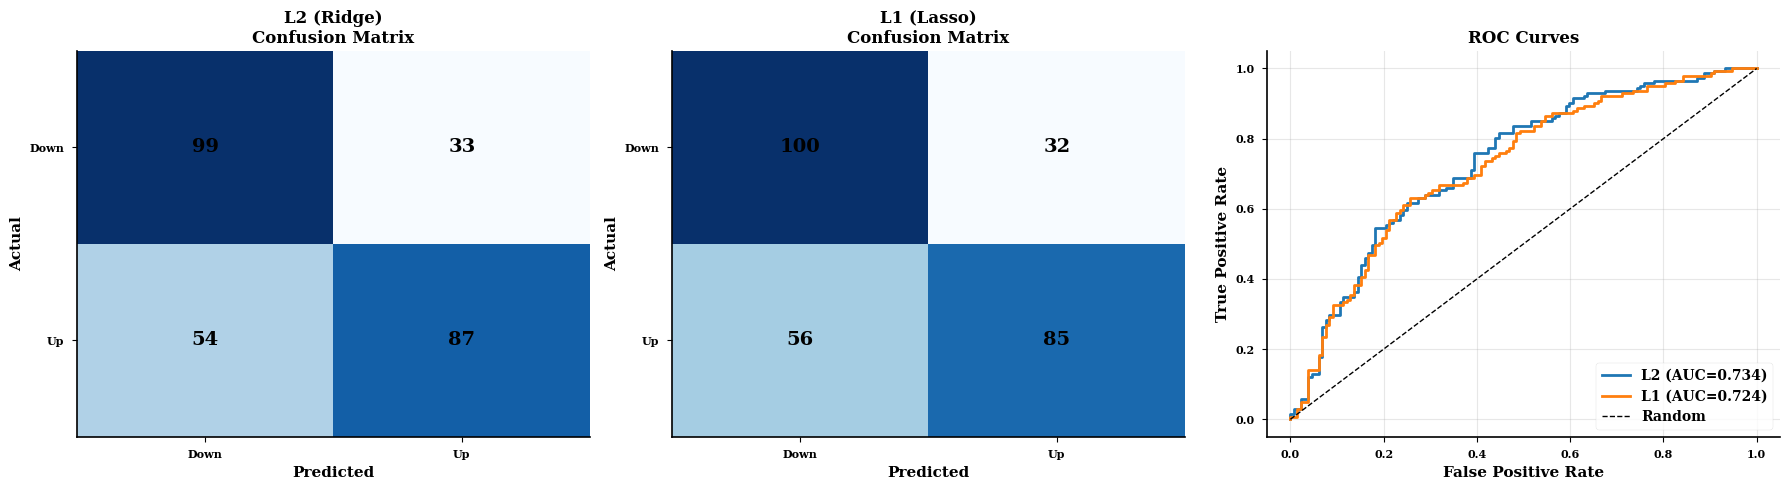


✓ Saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/baseline_models/baseline_performance.png


In [13]:
# Create comparison plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Confusion matrices
models = ["L2 (Ridge)", "L1 (Lasso)"]
cms = [cm_l2, cm_l1]

for i, (model_name, cm) in enumerate(zip(models, cms)):
    im = axes[i].imshow(cm, cmap="Blues", aspect="auto")
    axes[i].set_title(f"{model_name}\nConfusion Matrix", fontsize=12, fontweight="bold")
    axes[i].set_xlabel("Predicted", fontsize=11)
    axes[i].set_ylabel("Actual", fontsize=11)
    axes[i].set_xticks([0, 1])
    axes[i].set_yticks([0, 1])
    axes[i].set_xticklabels(["Down", "Up"])
    axes[i].set_yticklabels(["Down", "Up"])

    # Annotate cells
    for row in range(2):
        for col in range(2):
            axes[i].text(
                col,
                row,
                str(cm[row, col]),
                ha="center",
                va="center",
                fontsize=14,
                fontweight="bold",
            )

# Plot 3: ROC curves
fpr_l2, tpr_l2, _ = roc_curve(y_test, y_test_proba_l2)
fpr_l1, tpr_l1, _ = roc_curve(y_test, y_test_proba_l1)

axes[2].plot(
    fpr_l2,
    tpr_l2,
    linewidth=2,
    label=f"L2 (AUC={roc_auc_score(y_test, y_test_proba_l2):.3f})",
)
axes[2].plot(
    fpr_l1,
    tpr_l1,
    linewidth=2,
    label=f"L1 (AUC={roc_auc_score(y_test, y_test_proba_l1):.3f})",
)
axes[2].plot([0, 1], [0, 1], "k--", linewidth=1, label="Random")
axes[2].set_xlabel("False Positive Rate", fontsize=11)
axes[2].set_ylabel("True Positive Rate", fontsize=11)
axes[2].set_title("ROC Curves", fontsize=12, fontweight="bold")
axes[2].legend(loc="lower right", fontsize=10)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(baseline_dir / "baseline_performance.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✓ Saved to {baseline_dir / 'baseline_performance.png'}")

## 13. Feature Importance

Analyze which features are most important based on coefficient magnitudes


In [14]:
# Get feature importance from coefficients
feature_importance_l2 = pd.DataFrame(
    {
        "feature": feature_cols,
        "coefficient": lr_l2.coef_[0],
        "abs_coefficient": np.abs(lr_l2.coef_[0]),
    }
).sort_values("abs_coefficient", ascending=False)

feature_importance_l1 = pd.DataFrame(
    {
        "feature": feature_cols,
        "coefficient": lr_l1.coef_[0],
        "abs_coefficient": np.abs(lr_l1.coef_[0]),
    }
).sort_values("abs_coefficient", ascending=False)

print("=" * 80)
print("TOP 20 FEATURES BY ABSOLUTE COEFFICIENT (L2)")
print("=" * 80)
print(feature_importance_l2.head(20).to_string(index=False))

print("\n" + "=" * 80)
print("TOP 20 FEATURES BY ABSOLUTE COEFFICIENT (L1)")
print("=" * 80)
print(feature_importance_l1.head(20).to_string(index=False))

TOP 20 FEATURES BY ABSOLUTE COEFFICIENT (L2)
                       feature  coefficient  abs_coefficient
impact_permanent_impact_5_mean     1.135644         1.135644
                     agg_close     0.910162         0.910162
                      agg_vwap     0.886229         0.886229
                      agg_open     0.851796         0.851796
                       agg_low    -0.797535         0.797535
                 agg_mid_price    -0.784354         0.784354
                      agg_high    -0.769090         0.769090
       impact_temp_impact_mean     0.722216         0.722216
                  window_start     0.596300         0.596300
                    window_end    -0.477139         0.477139
                    agg_trades    -0.475075         0.475075
         agg_intrabar_momentum     0.457934         0.457934
        trade_volume_imbalance    -0.417996         0.417996
               adv_volume_skew     0.361277         0.361277
             adv_vol_ewma_fast     0.314

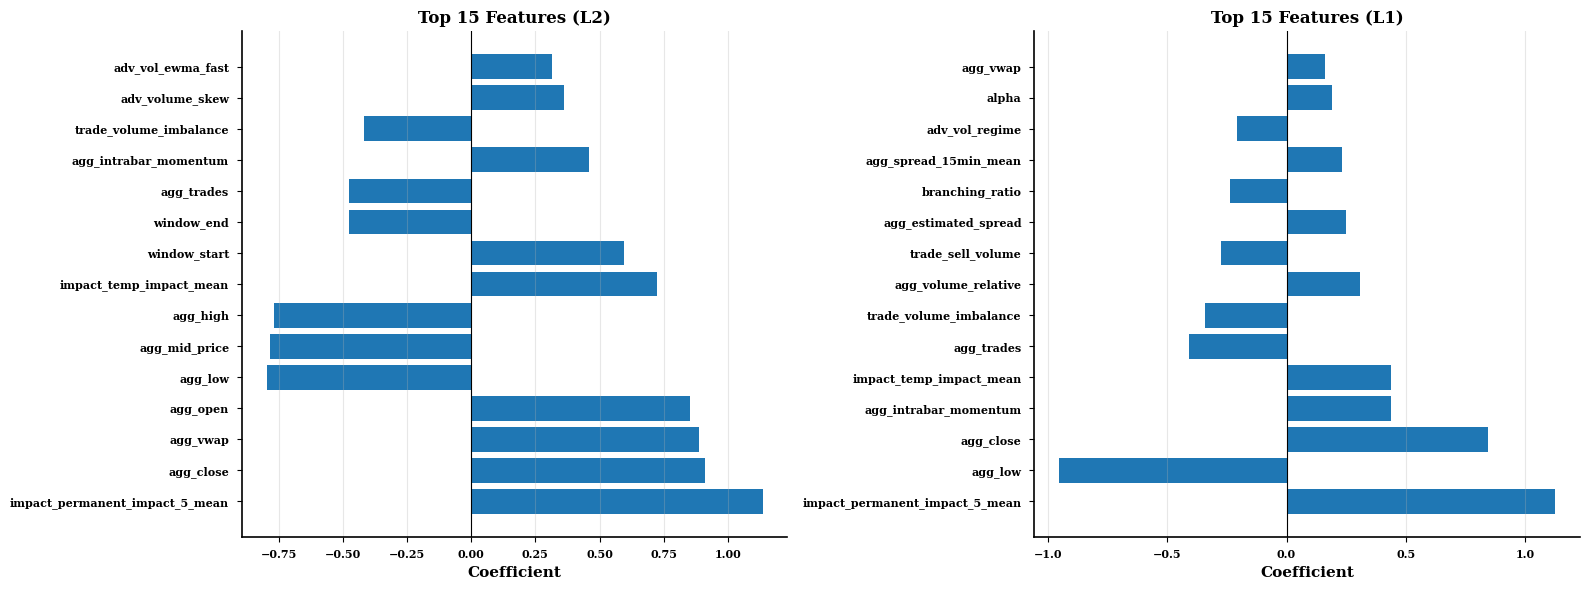


 Saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/baseline_models/feature_importance.png


In [15]:
# Visualize top features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# L2 top features
top_l2 = feature_importance_l2.head(15)
axes[0].barh(range(len(top_l2)), top_l2["coefficient"].values)
axes[0].set_yticks(range(len(top_l2)))
axes[0].set_yticklabels(top_l2["feature"].values)
axes[0].set_xlabel("Coefficient", fontsize=11)
axes[0].set_title("Top 15 Features (L2)", fontsize=12, fontweight="bold")
axes[0].axvline(0, color="k", linestyle="-", linewidth=0.8)
axes[0].grid(axis="x", alpha=0.3)

# L1 top features
top_l1 = feature_importance_l1.head(15)
axes[1].barh(range(len(top_l1)), top_l1["coefficient"].values)
axes[1].set_yticks(range(len(top_l1)))
axes[1].set_yticklabels(top_l1["feature"].values)
axes[1].set_xlabel("Coefficient", fontsize=11)
axes[1].set_title("Top 15 Features (L1)", fontsize=12, fontweight="bold")
axes[1].axvline(0, color="k", linestyle="-", linewidth=0.8)
axes[1].grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.savefig(baseline_dir / "feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n Saved to {baseline_dir / 'feature_importance.png'}")

## 14. Save Models and Results


In [16]:
# Save results
results = {
    "ticker": TICKER,
    "start_date": START_DATE,
    "end_date": END_DATE,
    "date_range": DATE_RANGE,
    "lr_l2": {
        "train_accuracy": float(accuracy_score(y_train, y_train_pred_l2)),
        "test_accuracy": float(accuracy_score(y_test, y_test_pred_l2)),
        "test_precision": float(precision_score(y_test, y_test_pred_l2)),
        "test_recall": float(recall_score(y_test, y_test_pred_l2)),
        "test_f1": float(f1_score(y_test, y_test_pred_l2)),
        "test_roc_auc": float(roc_auc_score(y_test, y_test_proba_l2)),
        "n_features": len(feature_cols),
        "converged": bool(lr_l2.n_iter_[0] < lr_l2.max_iter),
    },
    "lr_l1": {
        "train_accuracy": float(accuracy_score(y_train, y_train_pred_l1)),
        "test_accuracy": float(accuracy_score(y_test, y_test_pred_l1)),
        "test_precision": float(precision_score(y_test, y_test_pred_l1)),
        "test_recall": float(recall_score(y_test, y_test_pred_l1)),
        "test_f1": float(f1_score(y_test, y_test_pred_l1)),
        "test_roc_auc": float(roc_auc_score(y_test, y_test_proba_l1)),
        "n_features": len(feature_cols),
        "n_nonzero_coef": int(n_nonzero),
        "converged": bool(lr_l1.n_iter_[0] < lr_l1.max_iter),
    },
    "data_info": {
        "n_train": len(X_train),
        "n_test": len(X_test),
        "n_features": len(feature_cols),
        "target_col": "price_direction",
        "price_col": price_col,
    },
}

with open(MODELS_DIR / "baseline_results.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"\n Results saved to {MODELS_DIR / 'baseline_results.json'}")
print(f"\nResults summary:")
print(f"  Ticker: {TICKER}")
print(f"  Date range: {START_DATE} to {END_DATE} (5 trading days)")
print(f"  Train samples: {len(X_train):,}")
print(f"  Test samples: {len(X_test):,}")


 Results saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../models/baseline_results.json

Results summary:
  Ticker: AAPL
  Date range: 2024-12-09 to 2024-12-13 (5 trading days)
  Train samples: 1,091
  Test samples: 273


In [17]:
# Save results
results = {
    "lr_l2": {
        "train_accuracy": float(accuracy_score(y_train, y_train_pred_l2)),
        "test_accuracy": float(accuracy_score(y_test, y_test_pred_l2)),
        "test_precision": float(precision_score(y_test, y_test_pred_l2)),
        "test_recall": float(recall_score(y_test, y_test_pred_l2)),
        "test_f1": float(f1_score(y_test, y_test_pred_l2)),
        "test_roc_auc": float(roc_auc_score(y_test, y_test_proba_l2)),
        "n_features": len(feature_cols),
        "converged": bool(lr_l2.n_iter_[0] < lr_l2.max_iter),
    },
    "lr_l1": {
        "train_accuracy": float(accuracy_score(y_train, y_train_pred_l1)),
        "test_accuracy": float(accuracy_score(y_test, y_test_pred_l1)),
        "test_precision": float(precision_score(y_test, y_test_pred_l1)),
        "test_recall": float(recall_score(y_test, y_test_pred_l1)),
        "test_f1": float(f1_score(y_test, y_test_pred_l1)),
        "test_roc_auc": float(roc_auc_score(y_test, y_test_proba_l1)),
        "n_features": len(feature_cols),
        "n_nonzero_coef": int(n_nonzero),
        "converged": bool(lr_l1.n_iter_[0] < lr_l1.max_iter),
    },
    "data_info": {
        "n_train": len(X_train),
        "n_test": len(X_test),
        "n_features": len(feature_cols),
        "target_col": "price_direction",
        "price_col": price_col,
    },
}

with open(MODELS_DIR / "baseline_results.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"\n Results saved to {MODELS_DIR / 'baseline_results.json'}")


 Results saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../models/baseline_results.json


In [18]:
# Save feature importance
feature_importance_l2.to_csv(
    TABLES_DIR / "baseline_feature_importance_l2.csv", index=False
)
feature_importance_l1.to_csv(
    TABLES_DIR / "baseline_feature_importance_l1.csv", index=False
)

print("✓ Feature importance saved:")
print(f"  {TABLES_DIR / 'baseline_feature_importance_l2.csv'}")
print(f"  {TABLES_DIR / 'baseline_feature_importance_l1.csv'}")

✓ Feature importance saved:
  /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/tables/baseline_feature_importance_l2.csv
  /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/tables/baseline_feature_importance_l1.csv


In [19]:
print("=" * 80)
print("BASELINE MODELS SUMMARY")
print("=" * 80)

print(f"\nData:")
print(f"  Train samples: {len(X_train):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Features: {len(feature_cols)}")
print(f"  Target: Next-period price direction (up/down)")

print(f"\nLogistic Regression (L2 - Ridge):")
print(f"  Test Accuracy: {results['lr_l2']['test_accuracy']:.4f}")
print(f"  Test F1-score: {results['lr_l2']['test_f1']:.4f}")
print(f"  Test ROC-AUC:  {results['lr_l2']['test_roc_auc']:.4f}")

print(f"\nLogistic Regression (L1 - Lasso):")
print(f"  Test Accuracy: {results['lr_l1']['test_accuracy']:.4f}")
print(f"  Test F1-score: {results['lr_l1']['test_f1']:.4f}")
print(f"  Test ROC-AUC:  {results['lr_l1']['test_roc_auc']:.4f}")
print(f"  Features selected: {results['lr_l1']['n_nonzero_coef']}/{len(feature_cols)}")

print(f"\nKey Insights:")
print(f"  - Baseline accuracy established for comparison with tree models")
print(f"  - L1 performed automatic feature selection")
print(
    f"  - {'L2' if results['lr_l2']['test_accuracy'] > results['lr_l1']['test_accuracy'] else 'L1'} achieved better test accuracy"
)

print(f"\nNext Steps:")
print(f"  - Notebook 40: Decision Trees")
print(f"  - Notebook 45: Random Forest")
print(f"  - Notebook 50: Gradient Boosting")
print(f"  - Compare tree model performance vs. baseline")

print("\n" + "=" * 80)

BASELINE MODELS SUMMARY

Data:
  Train samples: 1,091
  Test samples: 273
  Features: 81
  Target: Next-period price direction (up/down)

Logistic Regression (L2 - Ridge):
  Test Accuracy: 0.6813
  Test F1-score: 0.6667
  Test ROC-AUC:  0.7337

Logistic Regression (L1 - Lasso):
  Test Accuracy: 0.6777
  Test F1-score: 0.6589
  Test ROC-AUC:  0.7241
  Features selected: 55/81

Key Insights:
  - Baseline accuracy established for comparison with tree models
  - L1 performed automatic feature selection
  - L2 achieved better test accuracy

Next Steps:
  - Notebook 40: Decision Trees
  - Notebook 45: Random Forest
  - Notebook 50: Gradient Boosting
  - Compare tree model performance vs. baseline

